In [2]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Optional
from typing import Union
from typing import Tuple
from typing import List
import torch.nn as nn
import numpy as np
import torch
import math
import os

In [3]:
train_dir= 'E:/CSY/university/summerlabtask/task4/data/mnist/train/mnist_train.csv'
test_dir= 'E:/CSY/university/summerlabtask/task4/data/mnist/test/mnist_test.csv'

In [4]:
def read_mnist(file_name):  #从CSV文件中读取mnist数据集，将其转化为pytorch张量，并归一化处理。
    mnist= []
    with open(file_name, encoding= 'utf-8') as f:
        mnist= f.readlines()
    rows= len(mnist)  #代表数据集中的样本数量
    mnist= np.array([int(item) for sting in mnist for item in sting.split(',')]).reshape(rows, -1)
    return torch.from_numpy(mnist[:, 1:]).float()/ 255.0, torch.from_numpy(mnist[:, 0])
    #返回标准化后的图像数据和对应的标签。

In [5]:
seed, batch_size= 1, 512
np.random.seed(seed) #随机数种子确保产生相同的随机数序列，使结果可复现
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
pics, labels= read_mnist(train_dir) #分割图像数据和标签数据
random_num= torch.rand(len(pics))  #生成一个与样本数量相同的随机张量
#划分训练集、验证集、测试集
train_flag, valid_flag, test_flag= random_num< torch.tensor(0.8), (random_num>= torch.tensor(0.8))* (random_num< torch.tensor(0.9)), random_num>= torch.tensor(0.9)
#提取训练集、验证集、测试集的图像
train_pics, valid_pics, test_pics= pics[train_flag], pics[valid_flag], pics[test_flag]
#提取训练集、验证集、测试集的标签
train_labels, valid_labels, test_labels= labels[train_flag], labels[valid_flag], labels[test_flag]
#创建训练集、验证集、测试集的图像+标签
train_set, valid_set, test_set= torch.utils.data.TensorDataset(train_pics, train_labels), torch.utils.data.TensorDataset(valid_pics, valid_labels), torch.utils.data.TensorDataset(test_pics, test_labels)
#创建训练集、验证集、测试集的数据加载器
train_loader, valid_loader, test_loader= torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(valid_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle= True)

In [6]:
class Tools:  #张量提取与形状调整。
    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        c= consts.gather(-1, t)
        return c.reshape(-1, 1, 1, 1)


In [7]:
class DenoiseDiffusion():
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma = self.beta
        self.tools = Tools()
    
    def q_xt_x0(self, x0: torch.tensor, t: torch.Tensor):
        maen = self.tools.gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - self.tools.gather(self.alpha_bar, t)
        return maen, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)  
        maen, var = self.q_xt_x0(x0, t)
        return maen + (var ** 0.5) * eps

    def p_sample(self, xt: torch.tensor, t: torch.Tensor, labels: torch.Tensor):
        eps_hat = self.eps_model(xt, t, labels)  # 传递标签
        alpha_bar = self.tools.gather(self.alpha_bar, t)
        alpha = self.tools.gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** 0.5
        maen = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_hat)
        var = self.tools.gather(self.sigma, t)
        eps = torch.randn(xt.shape, device=xt.device)
        return maen + (var ** 0.5) * eps
    
    def loss(self, x0: torch.tensor, labels: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
        if noise is None:
            noise = torch.randn_like(x0)
        xt = self.q_sample(x0, t, eps=noise)
        eps_hat = self.eps_model(xt, t, labels)  # 传递标签
        return F.mse_loss(noise, eps_hat)



In [8]:
class Swish(nn.Module): #非线性激活函数
    def forward(self, x):
        return x* torch.sigmoid(x)

In [9]:
class ResidualBolck(nn.Module):
    #带残差连接的卷积块
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int= 16, dropout: float= 0.1):
        super().__init__()
        
        self.norm1= nn.GroupNorm(n_groups, in_channels)
        self.act1= Swish()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size= (3, 3), padding= (1, 1))
        self.norm2= nn.GroupNorm(n_groups, out_channels)
        self.act2= Swish()
        self.conv2= nn.Conv2d(out_channels, out_channels, kernel_size= (3, 3), padding= (1, 1))
        if in_channels!= out_channels:
            self.shortcut= nn.Conv2d(in_channels, out_channels, kernel_size= (1, 1))
        else:
            self.shortcut= nn.Identity()
        self.time_emb= nn.Linear(time_channels, out_channels) #将时间信息映射到输出通道数的线性层
        self.time_act= Swish()  #激活函数，用于时间嵌入
        self.dropout= nn.Dropout(dropout)
    def forward(self, x: torch.Tensor, t:torch.Tensor):
        # norm>> act>> conv
        h= self.conv1(self.act1(self.norm1(x)))
        # time embedding, (batch_size, out_channels, 1, 1)
        # time embedding的不同特征与不同通道的特征图进行相加以实现空间与时间的融合
        h+= self.time_emb(self.time_act(t))[:, :, None, None] #时间嵌入
        h= self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h+ self.shortcut(x) #残差连接


In [10]:
class AttentionBlock(nn.Module): #自注意力模块
    #捕捉图像和序列数据中的长距离依赖关系，提高对特征图中重要信息的关注能力
    def __init__(self, n_channels: int, n_heads: int= 1, k_dims: int= None, n_groups: int= 16):
        super().__init__()
        if k_dims is None: #每个注意力头的维度
            k_dims= n_channels
        self.norm= nn.GroupNorm(n_groups, n_channels)
        # as n_channels= 64, 64>> 8* 128* 3
        self.projection= nn.Linear(n_channels, n_heads* k_dims* 3)
        self.output= nn.Linear(n_heads* k_dims, n_channels)
        self.scale= k_dims** -0.5
        self.n_heads= n_heads
        self.k_dims= k_dims
    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor]= None):
        _= t
        batch_size, n_channels, height, weight= x.shape
        # pull x straight, (batch_size, n_channels, H* W)>> (batch_size, H* W, n_channels)
        x= x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # (batch_size, H* W, channels)>> (batch_size, H* W, head, 3* k_head_dim)
        qkv= self.projection(x).view(batch_size, -1, self.n_heads, 3* self.k_dims)
        # q, (batch_size, H* W, head, k_head_dim); k, (batch_size, H* W, head, k_head_dim); v, (,,).
        q, k, v= torch.chunk(qkv, 3, dim= -1)
        # (batch_size, H* W, head, dim), (batch_size, H* W, head, dim) -> (batch_size, H* W, H* W, head)
        # This writing style is really good!
        attn= torch.einsum('bihd,bjhd->bijh', q, k)* self.scale
        attn= attn.softmax(dim= 2)
        # (batch_size, H* W, H* W, head), (batch_size, H* W, head, dim)
        res= torch.einsum('bijh,bjhd->bihd', attn, v)
        # (batch_size, H* W, head* dim)
        res= res.view(batch_size, -1, self.n_heads* self.k_dims)
        # (batch_size, H* W, C)
        res= self.output(res)
        res+= x #添加残差连接
        res= res.permute(0, 2, 1).view(batch_size, n_channels, height, weight)
        return res

In [11]:
class DownBlock(nn.Module):
    # Encoder
    # DownBlock= ResidualBlock+ AttentionBlock
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res= ResidualBolck(in_channels, out_channels, time_channels)
        if has_attn: #是否在块中包含自注意力机制
            self.attn= AttentionBlock(out_channels)
        else:
            self.attn= nn.Identity()
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        #print(f"DownBlock input shape: {x.shape}")
        x= self.res(x, t) #用残差块进行降维和特征提取（输入特征图和时间）
        x= self.attn(x) #用注意力机制增强特征表示
        #print(f"DownBlock output shape: {x.shape}")
        return x 

In [12]:
class TimeEmbedding(nn.Module): #用于时间编码的神经网络模块，引入时间相关信息
    def __init__(self, n_channels:int):
        super().__init__()
        self.n_channels= n_channels
        # n_channels// 8 and concate
        self.lin1= nn.Linear(self.n_channels// 4, self.n_channels) #线性层
        self.act= Swish() #激活函数
        self.lin2= nn.Linear(self.n_channels, self.n_channels) #线性层
    def forward(self, t: torch.Tensor):
        half_dim= self.n_channels// 8
        emb= math.log(10000)/ (half_dim- 1)
        emb= torch.exp(torch.arange(half_dim, device= t.device)* -emb)
        emb= t[:, None]* emb[None, :]
        emb= torch.cat((emb.sin(), emb.cos()), dim= 1) #将正弦和余弦函数应用于时间嵌入，得到周期性嵌入。
        # transform
        emb= self.act(self.lin1(emb))
        emb= self.lin2(emb)
        return emb        

In [13]:
class Upsample(nn.Module): #上采样（将特征图的分辨率增大）的神经网络模块
    #用于扩散模型中的解码器部分，帮助模型逐渐恢复输入图像的细节
    def __init__(self, n_channels):
        super().__init__()
        # 反卷积，
        self.conv= nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1)) #输入通道数，输出通道数，卷积核大小，步幅，填充
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _= t
        return self.conv(x)

In [14]:
class Downsample(nn.Module): #下采样（将特征图的分辨率降低）的神经网络模块
    #用于扩散模型的编码器部分，帮助模型提取更高级的特征，同时减少空间维度，减少计算
    def __init__(self, n_channels):
        super().__init__()
        self.conv= nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))
    def forward(self, x:torch.tensor, t:torch.tensor):
        _= t
        return self.conv(x)

In [15]:
class MiddleBlock(nn.Module): #中间块，用于在生成模型中处理中间阶段的特征提取和处理。
    def __init__(self, n_channels:int, time_channels:int):
        super().__init__()
        self.res1= ResidualBolck(n_channels, n_channels, time_channels)
        self.attn= AttentionBlock(n_channels)
        self.res2= ResidualBolck(n_channels, n_channels, time_channels)
    def forward(self, x:torch.tensor, t:torch.tensor):
        x= self.res1(x, t)
        x= self.attn(x)
        x= self.res2(x, t)
        return x #返回的特征图可以作为下一个块或模型的输入

In [16]:
class UpBlock(nn.Module): #上采样块，组合残差块和注意力机制，用于提取和增强特征
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # we concatenate the output of the same resolution
        self.res= ResidualBolck(in_channels+ out_channels, out_channels, time_channels)
        if has_attn:
            self.attn= AttentionBlock(out_channels)
        else:
            self.attn= nn.Identity()
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        #print(f"UpBlock input shape: {x.shape}")
        x= self.res(x, t)
        x= self.attn(x)
        #print(f"UpBlock output shape: {x.shape}")
        return x

In [17]:
class LabelEmbedding(nn.Module):
    def __init__(self, num_classes: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        
    def forward(self, labels: torch.Tensor):
        return self.embedding(labels)

In [18]:
class UNet(nn.Module):
    def __init__(self, image_channels: int=1, n_channels: int=16, ch_mults: Union[tuple[int, ...], List[int]]= [1, 2, 2, 2], is_attn: Union[Tuple[bool, ...], List[int]]= (False, False, False, False), n_blocks: int=1, num_classes: int=10):
        super().__init__()
        n_resolutions = len(ch_mults)
        self.label_emb = LabelEmbedding(num_classes, n_channels * 4)  # 标签嵌入

        # 计算总的输入通道数
        label_channels = n_channels * 4
        total_input_channels = image_channels + label_channels

        self.image_proj = nn.Conv2d(total_input_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))
        self.time_emb = TimeEmbedding(n_channels * 4)
        # self.label_emb = nn.Embedding(num_classes, n_channels * 4)
        down = []
        out_channels = in_channels = n_channels
        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))
        self.down = nn.ModuleList(down)
        self.middle = MiddleBlock(out_channels, n_channels * 4)
        up = []
        in_channels = out_channels
        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            if i > 0:
                up.append(Upsample(in_channels))
        self.up = nn.ModuleList(up)
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor, labels: torch.Tensor):
        #print(f"Input shape: {x.shape}")
        
        t = self.time_emb(t)
        #print(f"Time embedding shape: {t.shape}")
        
        label_emb = self.label_emb(labels).unsqueeze(-1).unsqueeze(-1)
        #print(f"Label embedding shape: {label_emb.shape}")
        
        x = torch.cat([x, label_emb.expand(-1, -1, x.size(2), x.size(3))], dim=1)
        #print(f"After concatenation shape: {x.shape}")
        
        x = self.image_proj(x)
        #print(f"After image_proj shape: {x.shape}")
        
        h = [x]
        for m in self.down:
            x = m(x, t)
            #print(f"After down block shape: {x.shape}")
            h.append(x)
        
        x = self.middle(x, t)
        #print(f"After middle block shape: {x.shape}")
        
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
                #print(f"After upsample shape: {x.shape}")
            else:
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #print(f"After concatenation with skip connection shape: {x.shape}")
                x = m(x, t)
                #print(f"After up block shape: {x.shape}")
        
        x = self.final(self.act(self.norm(x)))
        #print(f"After final layer shape: {x.shape}")
        
        return x


In [19]:
lr, device, save_dir= 0.001, 'cuda:0', './u_net2.pt'
u_net= UNet(1, 16, [1, 2, 2], [False, False, False], n_blocks= 1).to(device) #实例化UNet类
dm= DenoiseDiffusion(u_net, 1000, device= device) #实例化DDPM类，unet用于预测噪声
opt_dm= torch.optim.Adam(u_net.parameters(), lr= lr) #实例化优化器

In [184]:
best_score, score, epochs, early_stop_time, early_stop_threshold= 1e10, 0, 200, 0, 40
for epoch in range(epochs):
    loss_record = []
    for step, (pic, labels) in enumerate(train_loader):
        pic = pic.view(-1, 1, 28, 28).to(device)
        labels = labels.to(device)  # 确保标签也在设备上

        opt_dm.zero_grad()
        loss = dm.loss(pic, labels)  # 将标签传递给损失函数
        loss_record.append(loss.item())
        loss.backward()
        opt_dm.step()

    print(f'Training epoch: {epoch}, mean loss: {torch.tensor(loss_record).mean()}')
    
    # 验证
    loss_record = []
    with torch.no_grad():
        for step, (pic, labels) in enumerate(valid_loader):
            pic = pic.view(-1, 1, 28, 28).to(device)
            labels = labels.to(device)
            loss = dm.loss(pic, labels)  # 将标签传递给损失函数
            loss_record.append(loss.item())

    mean_loss = torch.tensor(loss_record).mean()

    # Early stopping
    if mean_loss < best_score:
        early_stop_time = 0
        best_score = mean_loss
        torch.save(u_net, f'{save_dir}')
    else:
        early_stop_time += 1

    if early_stop_time > early_stop_threshold:
        break

    # 输出
    print(f'Early stop time/early stop threshold: {early_stop_time}/{early_stop_threshold}, mean loss: {mean_loss}')

Training epoch: 0, mean loss: 0.18196065723896027
Early stop time/early stop threshold: 0/40, mean loss: 0.06961334496736526
Training epoch: 1, mean loss: 0.061867378652095795
Early stop time/early stop threshold: 0/40, mean loss: 0.05492229759693146
Training epoch: 2, mean loss: 0.04867758974432945
Early stop time/early stop threshold: 0/40, mean loss: 0.045056819915771484
Training epoch: 3, mean loss: 0.04324270784854889
Early stop time/early stop threshold: 0/40, mean loss: 0.036547448486089706
Training epoch: 4, mean loss: 0.03685460612177849
Early stop time/early stop threshold: 0/40, mean loss: 0.036415066570043564
Training epoch: 5, mean loss: 0.0333833321928978
Early stop time/early stop threshold: 0/40, mean loss: 0.034839529544115067
Training epoch: 6, mean loss: 0.03202301636338234
Early stop time/early stop threshold: 0/40, mean loss: 0.028944075107574463
Training epoch: 7, mean loss: 0.029675671830773354
Early stop time/early stop threshold: 0/40, mean loss: 0.027350187301

In [20]:
def show_sample(images, texts): #显示一组图像及其对应的文本标签
    _, figs= plt.subplots(1, len(images), figsize= (12, 12)  )
    for text, f, img in zip(texts, figs, images):
        f.imshow(img.view(28, 28), cmap= 'gray')
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        f.text(0.5, 0, text, ha= 'center', va= 'bottom', fontsize= 12, color= 'white', backgroundcolor= 'black')
    plt.show()

生成的标签值： tensor([0], device='cuda:0')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27996\813167123.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  u_net = torch.load(f'{save_dir}')


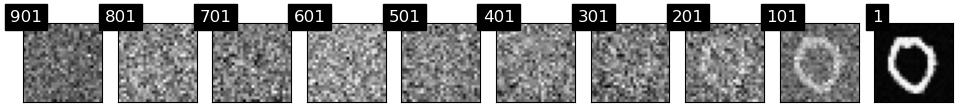

In [50]:
xt, images, texts = torch.randn((1, 1, 28, 28), device= device), [], []
labels = torch.tensor([0], device=device)  # 生成标签为0的图像
print("生成的标签值：", labels)
u_net = torch.load(f'{save_dir}')
dm = DenoiseDiffusion(u_net, 1000, device= device)

for t in reversed(range(1000)):
    xt_1 = dm.p_sample(xt, torch.tensor([t]).to(device), labels)  # 传递标签信息
    xt = xt_1
    if (t + 1) % 100 == 1:
        images.append(xt.view(1, 28, 28).to('cpu').detach())
        texts.append(t + 1)

images_ = torch.stack(images, dim= 0)
show_sample(images_, texts)
